# TMDB Box Office Prediction

In [1]:
# Importing Libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('max_columns', None)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV
import time
from datetime import datetime
from sklearn.metrics import mean_squared_error
import ast
from collections import Counter

## Dataset

Data Description 

id - Integer unique id of each movie

belongs_to_collection - Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format. You can see the Poster and Backdrop Image like this: https://image.tmdb.org/t/p/original/. Example: https://image.tmdb.org/t/p/original//iEhb00TGPucF0b4joM1ieyY026U.jpg

budget:Budget of a movie in dollars. 0 values mean unknown.

genres : Contains all the Genres Name & TMDB Id in JSON Format

homepage - Contains the official homepage URL of a movie. Example: http://sonyclassics.com/whiplash/ , this is the homepage of Whiplash movie.

imdb_id - IMDB id of a movie (string). You can visit the IMDB Page like this: https://www.imdb.com/title/

original_language - Two digit code of the original language, in which the movie was made. Like: en = English, fr = french.

original_title - The original title of a movie. Title & Original title may differ, if the original title is not in English.

overview - Brief description of the movie.

popularity - Popularity of the movie in float.

poster_path - Poster path of a movie. You can see the full image like this: https://image.tmdb.org/t/p/original/

production_companies - All production company name and TMDB id in JSON format of a movie.

production_countries - Two digit code and full name of the production company in JSON format.

release_date - Release date of a movie in mm/dd/yy format.

runtime - Total runtime of a movie in minutes (Integer).

spoken_languages - Two digit code and full name of the spoken language.

status - Is the movie released or rumored?

tagline - Tagline of a movie

title - English title of a movie

Keywords - TMDB Id and name of all the keywords in JSON format.

cast - All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format

crew - Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc.

revenue - Total revenue earned by a movie in dollars.

In this dataset, you are provided with 7398 movies and a variety of metadata obtained from The Movie Database (TMDB). Movies are labeled with id. Data points include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.

You are predicting the worldwide revenue for 4398 movies in the test file.


In [2]:
# Loading Dataset

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
# Training Data Overview

print("Training Dataset:")
train_data.head()

Training Dataset:


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
# Testing Data Overview

print("Testing Dataset:")
test_data.head()

Testing Dataset:


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [5]:
# Data Shape

print("Training Dataset shape:", train_data.shape)
print("Testing Dataset shape:",test_data.shape)

Training Dataset shape: (3000, 23)
Testing Dataset shape: (4398, 22)


There are 3000 rows in the training dataset spread across 23 attributes. 
There are 4398 rows in the testing dataset spread across 22 attributes. 

## Exploratory Data Analysis

#### Univariate Analysis

In [6]:
# Datatype Overview

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

Numerical Values: Id, Budget, Popularity, Runtime and Revenue. 
String Attributes: Belongs_to_Collection, Generes, Homepage, IMDB_Id, Original_Language, Original_Title, Overview, Popularity, Poster_Plan, Production_Companies, Production_Countries, Release_Date, Runtime, Spoken_Languages, Status, Tagline, Title, Keywords, Cast, Crew. 

In [8]:
# Train Data Statistics

train_data.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [9]:
# Test Data Statistics

test_data.describe()

,id,budget,popularity,runtime
count,4398.000000,4.398000e+03,4398.000000,4394.000000
mean,5199.500000,2.264929e+07,8.550230,107.622212
std,1269.737571,3.689991e+07,12.209014,21.058290
min,3001.000000,0.000000e+00,0.000001,0.000000
25%,4100.250000,0.000000e+00,3.895186,94.000000
50%,5199.500000,7.450000e+06,7.482242,104.000000
75%,6298.750000,2.800000e+07,10.938524,118.000000
max,7398.000000,2.600000e+08,547.488298,320.000000


In [10]:
# Checking for how many status are present in the training and testing dataset

train_data.groupby('status')['status'].agg('count')

status
Released    2996
Rumored        4
Name: status, dtype: int64

In [11]:
test_data.groupby('status')['status'].agg('count')

status
Post Production       5
Released           4389
Rumored               2
Name: status, dtype: int64

As there are few values which are other than 'Released' status so we will delete such records.  

In [12]:
train_data = train_data[~(train_data.status == 'Rumored')]
test_data = test_data[(test_data.status == 'Released')]

In [13]:
# Checking for how many status are present in the training and testing dataset

train_data.groupby('original_language')['original_language'].agg('count')

original_language
ar       1
bn       1
cn      20
cs       1
da       5
de      18
el       1
en    2571
es      43
fa       5
fi       2
fr      78
he       1
hi      42
hu       3
id       1
it      24
ja      37
ko      20
ml       2
mr       1
nb       1
nl       6
no       2
pl       2
pt       6
ro       4
ru      47
sr       1
sv       8
ta      16
te       2
tr       3
ur       1
vi       1
zh      19
Name: original_language, dtype: int64

In [14]:
test_data.groupby('original_language')['original_language'].agg('count')

original_language
af       1
bm       2
bn       2
ca       1
cn      21
cs       2
da      12
de      31
el       2
en    3769
es      52
fi       2
fr     121
he       5
hi      76
hu       1
id       2
is       1
it      31
ja      53
ka       1
kn       1
ko      29
ml      10
nl       5
no       3
pl       3
pt       7
ro       5
ru      61
sr       2
sv      12
ta      15
te       7
th       5
tr       6
ur       1
xx       2
zh      27
Name: original_language, dtype: int64

As we have movies in many languages so we will only choose English movies for revenue prediction. 

In [15]:
train_data1 = train_data[(train_data.original_language == 'en')]
test_data1 = test_data[(test_data.original_language == 'en')]

In [16]:
print("Training Dataset shape:", train_data.shape)
print("Shape of training dataset with English movies:", train_data1.shape)
print("Testing Dataset shape:",test_data.shape)
print("Shape of testing dataset with English movies:", test_data1.shape)

Training Dataset shape: (2996, 23)
Shape of training dataset with English movies: (2571, 23)
Testing Dataset shape: (4389, 22)
Shape of testing dataset with English movies: (3769, 22)


#### Visualization

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

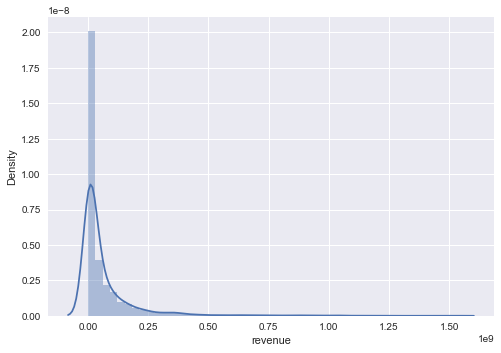

In [17]:
# Checking distribution of Response variable which is Revenue

sns.distplot(train_data.revenue)

The revenue is a skewed variable. 

<AxesSubplot:xlabel='budget', ylabel='revenue'>

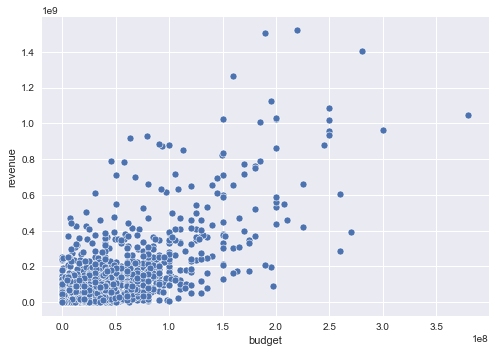

In [18]:
# Revenue Vs Budget

sns.scatterplot(data = train_data, x = "budget", y = "revenue")

<AxesSubplot:xlabel='popularity', ylabel='revenue'>

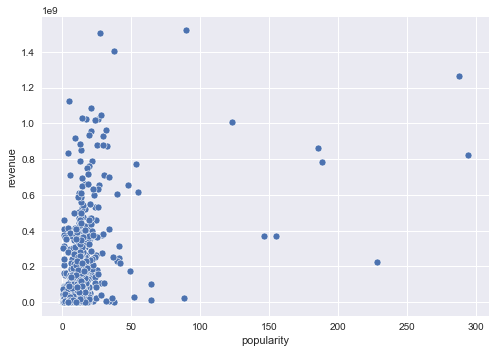

In [19]:
# Revenue Vs Popularity

sns.scatterplot(data = train_data, x = "popularity", y = "revenue")

<AxesSubplot:xlabel='runtime', ylabel='revenue'>

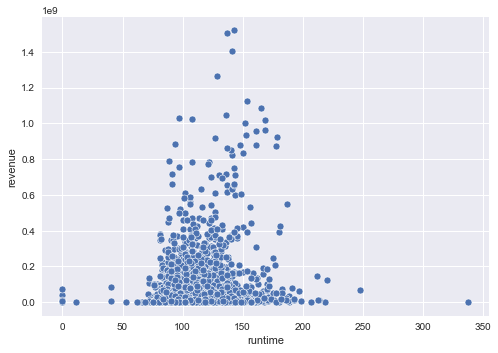

In [20]:
# Revenue Vs Runtime

sns.scatterplot(data = train_data, x = "runtime", y = "revenue")

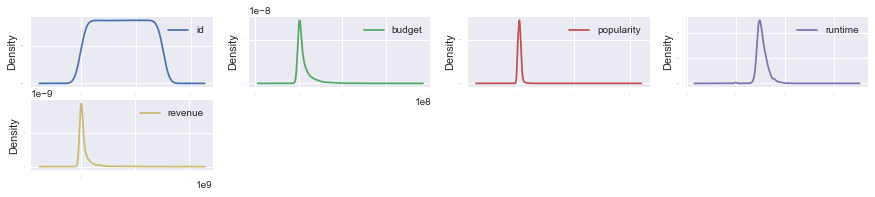

In [21]:
# Checking distribution of Predictors in Training Data

train_data.plot(kind='density', subplots=True, layout=(8,4), sharex=False, legend=True, fontsize=1, figsize=(15,12))
plt.show()

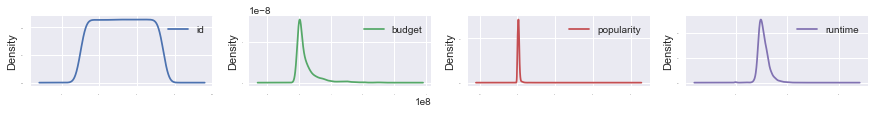

In [22]:
# Checking distribution of Predictors in Testing Data

test_data.plot(kind='density', subplots=True, layout=(8,4), sharex=False, legend=True, fontsize=1, figsize=(15,12))
plt.show()

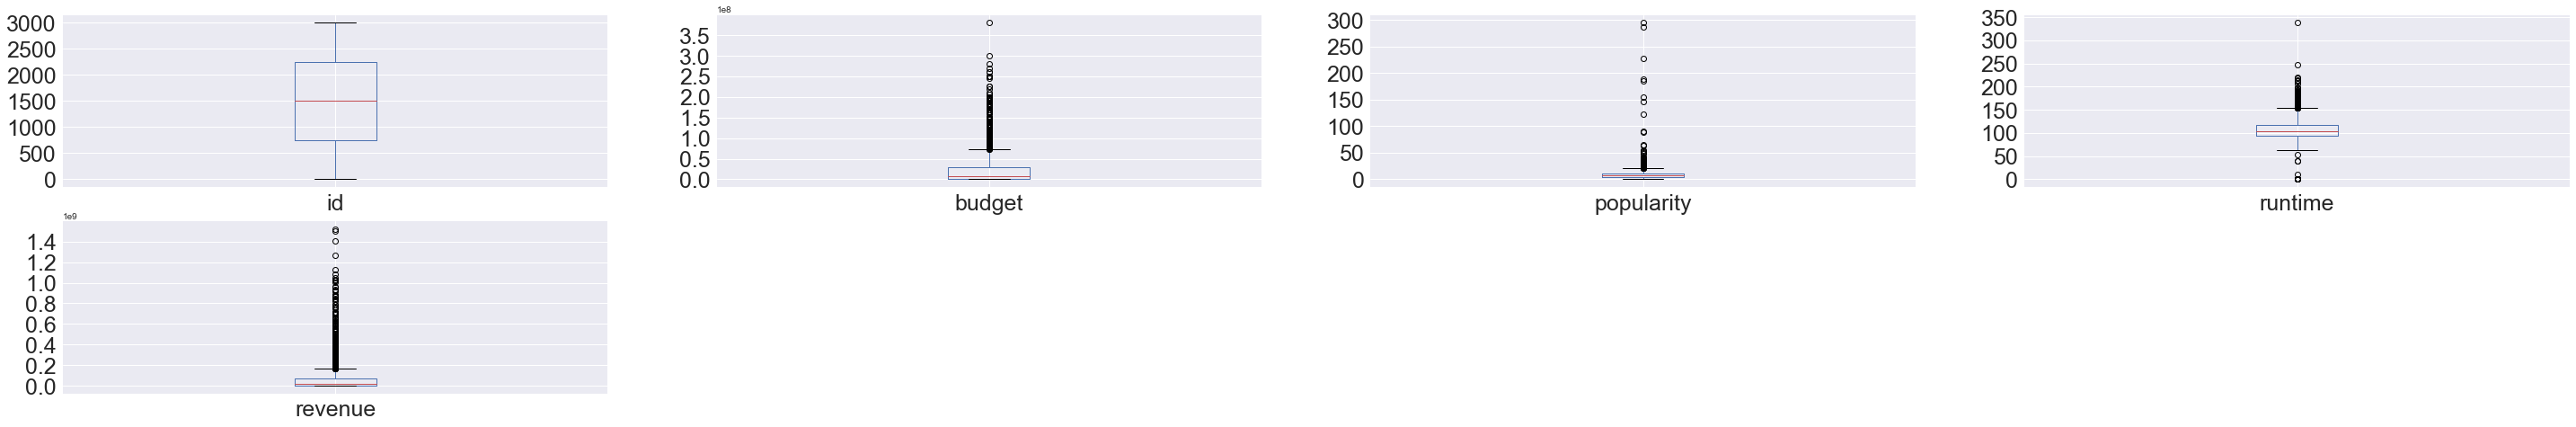

In [23]:
# Box Plot in Training Data

train_data.plot(kind='box', subplots=True, layout=(12,4), sharex=False, sharey=False,fontsize=25, figsize = (50, 50))
plt.show()

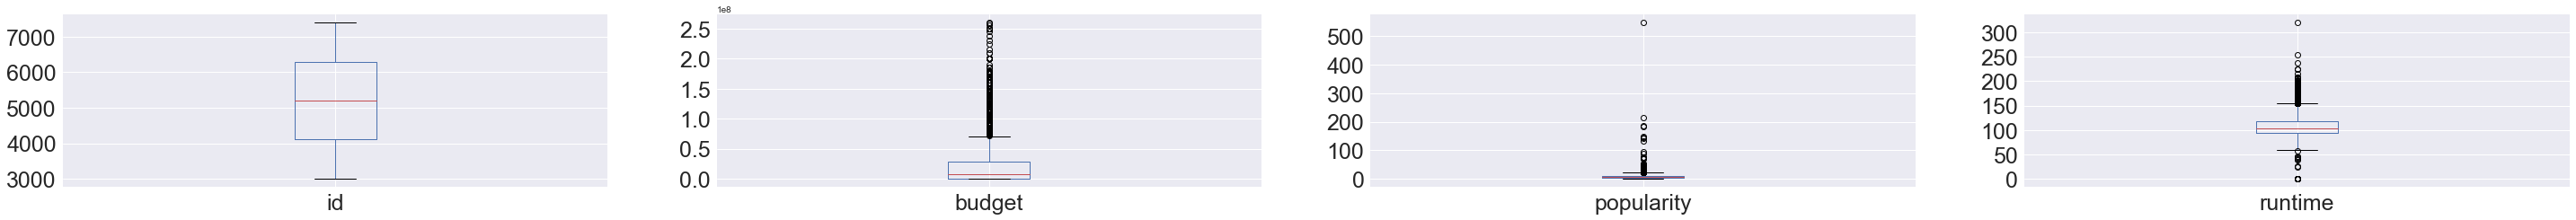

In [24]:
# Box Plot in Testing Data

test_data.plot(kind='box', subplots=True, layout=(12,4), sharex=False, sharey=False,fontsize=25, figsize = (50, 50))
plt.show()

We can see that there are many outliers in Budget, Popularity, Runtime and Revenue variables. We will treat outliers for variables Budget and Runtime as Revenue and Popularity outliers can be natural.

## Outlier Treatment

#### Training Dataset

In [25]:
# Treating outliers base on quartiles

bq_low = train_data1['budget'].quantile(0.01)
bq_hi  = train_data1['budget'].quantile(0.99)
rq_low = train_data1['runtime'].quantile(0.01)
rq_hi  = train_data1['runtime'].quantile(0.99)

train_data2 = train_data1.copy()
train_data2 = train_data2[(train_data2['budget'] < bq_hi) & (train_data2['budget'] > bq_low) & (train_data2['runtime'] < rq_hi) & (train_data2['runtime'] > rq_low)]

print("Shape of original training dataset:", train_data.shape)
print("Shape of training dataset with English movies:", train_data1.shape)
print("Shape of training dataset after outlier removal:", train_data2.shape)

Shape of original training dataset: (2996, 23)
Shape of training dataset with English movies: (2571, 23)
Shape of training dataset after outlier removal: (1881, 23)


Text(0.5, 1.0, 'Boxplot of Budget before outlier removal')

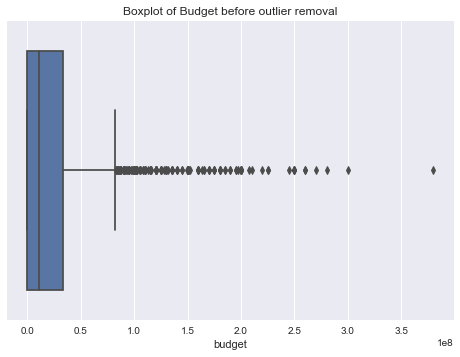

In [26]:
# Budget Variable in Training Data before Outlier Removal

sns.boxplot(x=train_data1['budget'])
plt.title('Boxplot of Budget before outlier removal')

Text(0.5, 1.0, 'Boxplot of Budget after outlier removal')

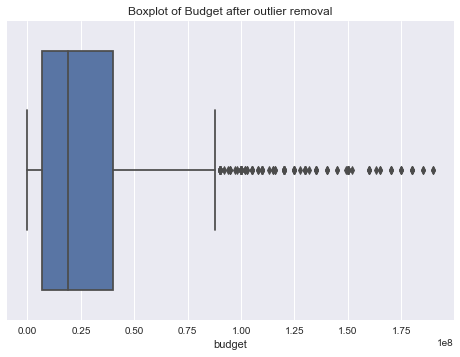

In [27]:
# Budget Variable in Training Data after Outlier Removal

sns.boxplot(x=train_data2['budget'])
plt.title('Boxplot of Budget after outlier removal')

Text(0.5, 1.0, 'Boxplot of Runtime before outlier removal')

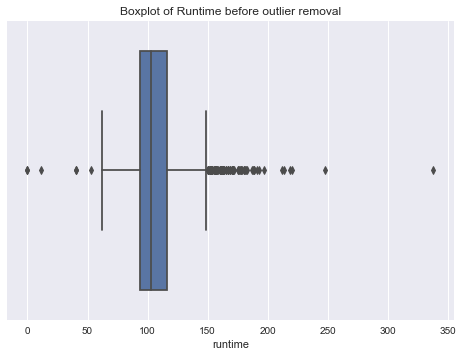

In [28]:
# Runtime Variable in Training Data before Outlier Removal

sns.boxplot(x=train_data1['runtime'])
plt.title('Boxplot of Runtime before outlier removal')

Text(0.5, 1.0, 'Boxplot of Runtime after outlier removal')

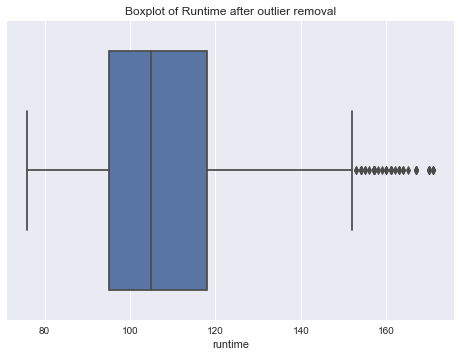

In [29]:
# Runtime Variable in Training Data after Outlier Removal

sns.boxplot(x=train_data2['runtime'])
plt.title('Boxplot of Runtime after outlier removal')

#### Testing Dataset

In [30]:
# Treating outliers base on quartiles

bq_low = test_data1['budget'].quantile(0.01)
bq_hi  = test_data1['budget'].quantile(0.99)
rq_low = test_data1['runtime'].quantile(0.01)
rq_hi  = test_data1['runtime'].quantile(0.99)

test_data2 = test_data1.copy()
test_data2 = test_data2[(test_data2['budget'] < bq_hi) & (test_data2['budget'] > bq_low) & (test_data2['runtime'] < rq_hi) & (test_data2['runtime'] > rq_low)]

print("Shape of original testing dataset:", test_data.shape)
print("Shape of testing dataset with English movies:", test_data1.shape)
print("Shape of testing dataset after outlier removal:", test_data2.shape)

Shape of original testing dataset: (4389, 22)
Shape of testing dataset with English movies: (3769, 22)
Shape of testing dataset after outlier removal: (2746, 22)


Text(0.5, 1.0, 'Boxplot of Budget before outlier removal')

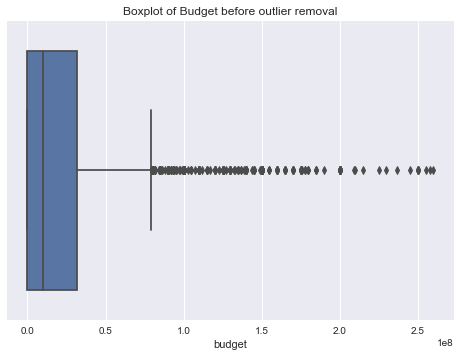

In [31]:
# Budget Variable in Testing Data before Outlier Removal

sns.boxplot(x=test_data1['budget'])
plt.title('Boxplot of Budget before outlier removal')

Text(0.5, 1.0, 'Boxplot of Budget after outlier removal')

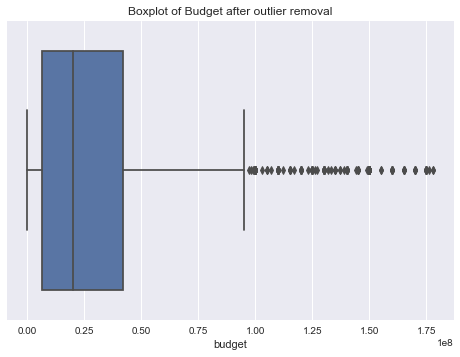

In [32]:
# Budget Variable in Testing Data after Outlier Removal

sns.boxplot(x=test_data2['budget'])
plt.title('Boxplot of Budget after outlier removal')

Text(0.5, 1.0, 'Boxplot of Runtime before outlier removal')

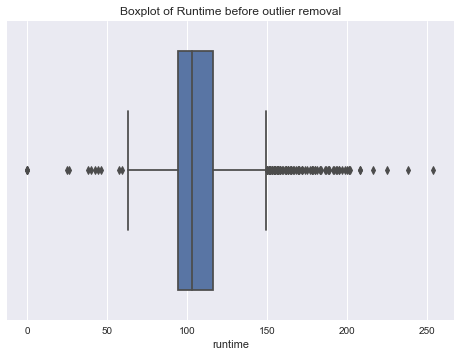

In [33]:
# Runtime Variable in Testing Data before Outlier Removal

sns.boxplot(x=test_data1['runtime'])
plt.title('Boxplot of Runtime before outlier removal')

Text(0.5, 1.0, 'Boxplot of Runtime after outlier removal')

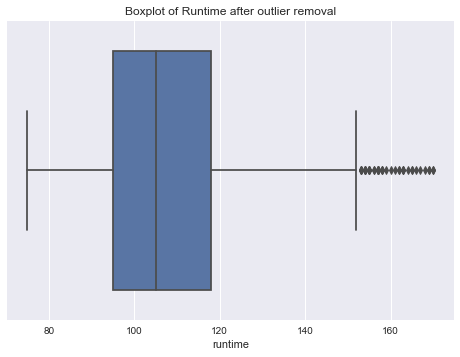

In [34]:
# Runtime Variable in Testing Data after Outlier Removal

sns.boxplot(x=test_data2['runtime'])
plt.title('Boxplot of Runtime after outlier removal')

The dataset still has some outliers but we will keep them as in films we can have some natural outliers. 

## Imputing Missing Values

In [35]:
# Training Dataset

train_data2.isnull().sum()

id                          0
belongs_to_collection    1459
budget                      0
genres                      4
homepage                 1217
imdb_id                     0
original_language           0
original_title              0
overview                    0
popularity                  0
poster_path                 0
production_companies       51
production_countries       15
release_date                0
runtime                     0
spoken_languages            6
status                      0
tagline                   168
title                       0
Keywords                   87
cast                        9
crew                       10
revenue                     0
dtype: int64

In [36]:
# Testing Dataset

test_data2.isnull().sum()

id                          0
belongs_to_collection    2116
budget                      0
genres                      6
homepage                 1768
imdb_id                     0
original_language           0
original_title              0
overview                    0
popularity                  0
poster_path                 0
production_companies       72
production_countries       36
release_date                0
runtime                     0
spoken_languages           17
status                      0
tagline                   269
title                       1
Keywords                  117
cast                       12
crew                       14
dtype: int64

After feature engineering we are going to remove the columns 'belongs_to_collection', 'homepage', 'production_companies', 'production_countries', 'tagline', 'Keywords', 'cast', 'crew'. 

## Feature Engineering

In feature engineering we will drop the columns which are not necessary for revenue prediction and generate few columns which are in originally in dictionary format. 

In [37]:
# Making copy of training and testing datasets.

train_data3 = train_data2.copy()
test_data3 = test_data2.copy()

#### Belongs_To_Collection arrtibute is in dictionary format so we will create a new column collection name with the name of collection. Also we will have 1 more column which will tell us if a movie has collection or not. 

In [38]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

In [39]:
# Training Dataset

train_data3 = text_to_dict(train_data3)

# Creates a new column with collection name

train_data3['collection_name'] = train_data3['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
print(train_data3['collection_name'].head())

# Creates a bool val if in collection or not

train_data3['has_collection'] = train_data3['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)
print(train_data3['has_collection'].head())

0    Hot Tub Time Machine Collection
1    The Princess Diaries Collection
2                                  0
5                                  0
6                                  0
Name: collection_name, dtype: object
0    1
1    1
2    0
5    0
6    0
Name: has_collection, dtype: int64


In [40]:
# Testing Dataset

test_data3 = text_to_dict(test_data3)

# Creates a new column with collection name

test_data3['collection_name'] = test_data3['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
print(test_data3['collection_name'].head())

# Creates a bool val if in collection or not

test_data3['has_collection'] = test_data3['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)
print(test_data3['has_collection'].head())

4                        0
7                        0
8                        0
9     Toy Story Collection
10                       0
Name: collection_name, dtype: object
4     0
7     0
8     0
9     1
10    0
Name: has_collection, dtype: int64


In [41]:
print(train_data3.shape)
print(test_data3.shape)

(1881, 25)
(2746, 24)


#### Genres is an attribute in dictionary format. We will first know what all are the different types of genres in the entire dataset and then create a list from it. Then we will have a column 'num_genres' which has total genres in any movie. Then we will have an attribute 'all_genres' which has all the genres in that movie. Also we will have seperate columns for all genres in categorical one hot encoding style specifying if it has any of the top 10 genres.

In [42]:
# Training Dataset

# Creates a list of all the possible genres

list_of_genres = list(train_data3['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Creates a num_genres column on the train df that has the number of genres that a movie has.

train_data3['num_genres'] = train_data3['genres'].apply(lambda x: len(x) if x != {} else 0)

# Creates a column on the train df that takes all the genres out of the Dictionary 

train_data3['all_genres'] = train_data3['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Create a list of unique genres for Training dataframe

unique_genres = []
for l in list_of_genres:
    for g in l:
        if g not in unique_genres:
            unique_genres.append(g)
        else:
            pass

# Create a separate column for all the genres with bool values if true

for g in unique_genres:
    train_data3['genre_' + g] = train_data3['all_genres'].apply(lambda x: 1 if g in x else 0)

In [43]:
# Testing Dataset

# Creates a list of all the possible genres

list_of_genres = list(test_data3['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Creates a num_genres column on the train df that has the number of genres that a movie has.

test_data3['num_genres'] = test_data3['genres'].apply(lambda x: len(x) if x != {} else 0)

# Creates a column on the train df that takes all the genres out of the Dictionary 

test_data3['all_genres'] = test_data3['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Create a separate column for all the genres with bool values if true

for g in unique_genres:
    test_data3['genre_' + g] = test_data3['all_genres'].apply(lambda x: 1 if g in x else 0)

In [44]:
print(train_data3.shape)
print(test_data3.shape)

(1881, 47)
(2746, 46)


#### Production Company is also in a dictionary so we will create a list of all production companies. Then we will have 2 new attributes having count of production campanies and their names. Also we will create columns in one hot encoding format specifying if the movie has any of the top 10 production companies.

In [45]:
# Training Dataset

# Creates a list of all the possible production companies

list_of_production = list(train_data3['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Creates a num_prod_co column on the train df that has the number of genres that a movie has.

train_data3['num_prod_co'] = train_data3['production_companies'].apply(lambda x: len(x) if x != {} else 0)

# Creates a column on the train df that takes all the production companies out of the Dictionary 

train_data3['all_prod_co'] = train_data3['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Create a list of unique genres for Training dataframe

unique_prod_co = []
for l in list_of_production:
    for g in l:
        if g not in unique_prod_co:
            unique_prod_co.append(g)
        else:
            pass
print(" There are "+ str(len(unique_prod_co)) + " unique Production Companies")

# Creates a boolean column on the train df for each of the possible production co

top_prod_co = [m[0] for m in Counter([i for j in list_of_production for i in j]).most_common(15)]
for g in top_prod_co:
    train_data3['prod_co_' + g] = train_data3['all_prod_co'].apply(lambda x: 1 if g in x else 0)
    
top_prod_co

 There are 2363 unique Production Companies


['Warner Bros.',
 'Universal Pictures',
 'Paramount Pictures',
 'Twentieth Century Fox Film Corporation',
 'Columbia Pictures',
 'New Line Cinema',
 'Metro-Goldwyn-Mayer (MGM)',
 'Touchstone Pictures',
 'Columbia Pictures Corporation',
 'Relativity Media',
 'Walt Disney Pictures',
 'TriStar Pictures',
 'Village Roadshow Pictures',
 'United Artists',
 'Miramax Films']

In [46]:
# Testing Dataset

# Creates a list of all the possible production companies

list_of_production = list(test_data3['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Creates a num_prod_co column on the train df that has the number of genres that a movie has.

test_data3['num_prod_co'] = test_data3['production_companies'].apply(lambda x: len(x) if x != {} else 0)

# Creates a column on the train df that takes all the production companies out of the Dictionary 

test_data3['all_prod_co'] = test_data3['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Create a list of unique genres for Training dataframe

unique_prod_co = []
for l in list_of_production:
    for g in l:
        if g not in unique_prod_co:
            unique_prod_co.append(g)
        else:
            pass
print(" There are "+ str(len(unique_prod_co)) + " unique Production Companies")

# Creates a boolean column on the train df for each of the possible production co

for g in top_prod_co:
    test_data3['prod_co_' + g] = test_data3['all_prod_co'].apply(lambda x: 1 if g in x else 0)

 There are 3174 unique Production Companies


In [47]:
print(train_data3.shape)
print(test_data3.shape)

(1881, 64)
(2746, 63)


#### Keywords: We will create a list of all the keywords in the dataset. Then we will have 2 new attributes containing number of keywords and all keywords names in it. Also we will add 10 new attributes specifying if the movie has any of the top 10 keywords in it. 

In [48]:
# Training Dataset

# Creates a list of all the possible keywords

list_of_keywords = list(train_data3['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Creates a num_keywords column on the train df that has the number of keywords.

train_data3['num_keywords'] = train_data3['Keywords'].apply(lambda x: len(x) if x != {} else 0)

# Creates a column on the train df that takes all the keywords out of the Dictionary 

train_data3['all_keywords'] = train_data3['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Create a list of unique keywords for Training dataframe

unique_keywords = []
for l in list_of_keywords:
    for g in l:
        if g not in unique_keywords:
            unique_keywords.append(g)
        else:
            pass
print(" There are "+ str(len(unique_keywords)) + " unique Keywords")

# Creates a boolean column on the train df for each of the possible keywords

top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(15)]
for g in top_keywords:
    train_data3['keyword_' + g] = train_data3['all_keywords'].apply(lambda x: 1 if g in x else 0)

 There are 6082 unique Keywords


In [49]:
# Testing Dataset

# Creates a list of all the possible keywords

list_of_keywords = list(test_data3['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Creates a num_keywords column on the train df that has the number of keywords.

test_data3['num_keywords'] = test_data3['Keywords'].apply(lambda x: len(x) if x != {} else 0)

# Creates a column on the train df that takes all the keywords out of the Dictionary 

test_data3['all_keywords'] = test_data3['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Create a list of unique keywords for Training dataframe

unique_keywords = []
for l in list_of_keywords:
    for g in l:
        if g not in unique_keywords:
            unique_keywords.append(g)
        else:
            pass
print(" There are "+ str(len(unique_keywords)) + " unique Keywords")

# Creates a boolean column on the train df for each of the possible keywords

for g in top_keywords:
    test_data3['keyword_' + g] = test_data3['all_keywords'].apply(lambda x: 1 if g in x else 0)

 There are 7473 unique Keywords


In [50]:
print(train_data3.shape)
print(test_data3.shape)

(1881, 81)
(2746, 80)


#### Production_Countries: We will create a list of all the production_countries in the dataset. Then we will have 2 new attributes containing number of countries and all countries names in it. Then we will choose top 10 countries and create 10 new columns. 

In [51]:
# Training Dataset

# Creates a list of all the possible production countries

list_of_country = list(train_data3['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Creates a num_prod_cty column on the train df that has the number of production countries that a movie has.

train_data3['num_prod_cty'] = train_data3['production_countries'].apply(lambda x: len(x) if x != {} else 0)

# Creates a column on the train df that takes all the production countries out of the Dictionary 

train_data3['all_prod_cty'] = train_data3['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Create a list of unique countries for Training dataframe

unique_prod_cty = []
for l in list_of_country:
    for g in l:
        if g not in unique_prod_cty:
            unique_prod_cty.append(g)
        else:
            pass
print(" There are "+ str(len(unique_prod_cty)) + " unique Production Companies")

top_country = [m[0] for m in Counter([i for j in list_of_country for i in j]).most_common(15)]
for g in top_country:
    train_data3['country_' + g] = train_data3['all_prod_cty'].apply(lambda x: 1 if g in x else 0)

 There are 59 unique Production Companies


In [52]:
# Testing Dataset

# Creates a list of all the possible production countries

list_of_country = list(test_data3['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Creates a num_prod_cty column on the train df that has the number of production countries that a movie has.

test_data3['num_prod_cty'] = test_data3['production_countries'].apply(lambda x: len(x) if x != {} else 0)

# Creates a column on the train df that takes all the production countries out of the Dictionary 

test_data3['all_prod_cty'] = test_data3['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Create a list of unique countries for Training dataframe

unique_prod_cty = []
for l in list_of_country:
    for g in l:
        if g not in unique_prod_cty:
            unique_prod_cty.append(g)
        else:
            pass
print(" There are "+ str(len(unique_prod_cty)) + " unique Production Companies")

for g in top_country:
    test_data3['country_' + g] = test_data3['all_prod_cty'].apply(lambda x: 1 if g in x else 0)

 There are 58 unique Production Companies


In [53]:
print(train_data3.shape)
print(test_data3.shape)

(1881, 98)
(2746, 97)


#### Cast: We will create a list of all the cast in the dataset. Then we will have 2 new attributes containing number of cast and all cast names in it. Also we will add 10 new attributes specifying if the movie has any of the top 10 cast in it. 

In [54]:
# Training Dataset

# creates a list of all the possible cast

list_of_cast = list(train_data3['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# creates a num_keywords column on the train df that has the number of keywords.

train_data3['num_cast'] = train_data3['cast'].apply(lambda x: len(x) if x != {} else 0)

# creates a column on the train df that takes all the keywords out of the Dictionary 

train_data3['all_cast'] = train_data3['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# create a list of unique keywords for Training dataframe

unique_cast = []
for l in list_of_cast:
    for g in l:
        if g not in unique_cast:
            unique_cast.append(g)
        else:
            pass
print(" There are "+ str(len(unique_cast)) + " unique cast")

# creates a boolean column on the train df for each of the possible keywords

top_cast = [m[0] for m in Counter([i for j in list_of_cast for i in j]).most_common(15)]
for g in top_cast:
    train_data3['cast_' + g] = train_data3['all_cast'].apply(lambda x: 1 if g in x else 0)

 There are 28031 unique cast


In [55]:
# Testing Dataset

# creates a list of all the possible cast

list_of_cast = list(test_data3['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# creates a num_keywords column on the train df that has the number of keywords.

test_data3['num_cast'] = test_data3['cast'].apply(lambda x: len(x) if x != {} else 0)

# creates a column on the train df that takes all the keywords out of the Dictionary 

test_data3['all_cast'] = test_data3['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# create a list of unique keywords for Training dataframe

unique_cast = []
for l in list_of_cast:
    for g in l:
        if g not in unique_cast:
            unique_cast.append(g)
        else:
            pass
print(" There are "+ str(len(unique_cast)) + " unique cast")

# creates a boolean column on the train df for each of the possible keywords

for g in top_cast:
    test_data3['cast_' + g] = test_data3['all_cast'].apply(lambda x: 1 if g in x else 0)

 There are 38262 unique cast


In [56]:
print(train_data3.shape)
print(test_data3.shape)

(1881, 115)
(2746, 114)


#### Crew: We will create a list of all the crew in the dataset. Then we will have 2 new attributes containing number of crew and all crew names in it. Also we will add 10 new attributes specifying if the movie has any of the top 10 crew in it. 

In [57]:
# Training Dataset

# Creates a list of all the possible cast

list_of_crew = list(train_data3['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Creates a num_keywords column on the train df that has the number of keywords.

train_data3['num_crew'] = train_data3['crew'].apply(lambda x: len(x) if x != {} else 0)

# Creates a column on the train df that takes all the keywords out of the Dictionary 

train_data3['all_crew'] = train_data3['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Create a list of unique keywords for Training dataframe

unique_crew = []
for l in list_of_crew:
    for g in l:
        if g not in unique_crew:
            unique_crew.append(g)
        else:
            pass
print(" There are "+ str(len(unique_crew)) + " unique cast")

# Creates a boolean column on the train df for each of the possible keywords

top_crew = [m[0] for m in Counter([i for j in list_of_crew for i in j]).most_common(15)]
for g in top_crew:
    train_data3['crew_' + g] = train_data3['all_crew'].apply(lambda x: 1 if g in x else 0)

top_crew

 There are 30105 unique cast


['Robert Rodriguez',
 'James Newton Howard',
 'Francine Maisler',
 'Deborah Aquila',
 'Avy Kaufman',
 'Jerry Goldsmith',
 'Mary Vernieu',
 'Steven Spielberg',
 'Tricia Wood',
 'John Debney',
 'Janet Hirshenson',
 'Mindy Marin',
 'John Papsidera',
 'Neal H. Moritz',
 'James Horner']

In [58]:
# Testing Dataset

# Creates a list of all the possible cast

list_of_crew = list(test_data3['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Creates a num_keywords column on the train df that has the number of keywords.

test_data3['num_crew'] = test_data3['crew'].apply(lambda x: len(x) if x != {} else 0)

# Creates a column on the train df that takes all the keywords out of the Dictionary 

test_data3['all_crew'] = test_data3['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

# Create a list of unique keywords for Training dataframe

unique_crew = []
for l in list_of_crew:
    for g in l:
        if g not in unique_crew:
            unique_crew.append(g)
        else:
            pass
print(" There are "+ str(len(unique_crew)) + " unique cast")

# Creates a boolean column on the train df for each of the possible keywords

for g in top_crew:
    test_data3['crew_' + g] = test_data3['all_crew'].apply(lambda x: 1 if g in x else 0)


 There are 38710 unique cast


In [59]:
print(train_data3.shape)
print(test_data3.shape)

(1881, 132)
(2746, 131)


#### We will add some features using Date of Release of movie like release month and day of week.

In [60]:
# Training Dataset

train_data3['release_date'] = pd.DataFrame(pd.to_datetime(train_data3['release_date'],dayfirst=True))

train_data3['release_month'] = train_data3['release_date'].dt.month

train_data3['release_DOW'] = train_data3['release_date'].dt.dayofweek

train_data3['release_year'] = train_data3['release_date'].dt.year

In [61]:
# Testing Dataset

test_data3['release_date'] = pd.DataFrame(pd.to_datetime(test_data3['release_date'],dayfirst=True))

test_data3['release_month'] = test_data3['release_date'].dt.month

test_data3['release_DOW'] = test_data3['release_date'].dt.dayofweek

test_data3['release_year'] = test_data3['release_date'].dt.year

In [62]:
# Checking the shape of training dataset after feature engineering

print("The original training dataset's shape is: ", train_data.shape)
print("Shape of training dataset with English movies:", train_data1.shape)
print("The generated training dataset's shape after outlier treatment is: ", train_data2.shape)
print("The generated training dataset's shape after feature engineering is: ", train_data3.shape)

The original training dataset's shape is:  (2996, 23)
Shape of training dataset with English movies: (2571, 23)
The generated training dataset's shape after outlier treatment is:  (1881, 23)
The generated training dataset's shape after feature engineering is:  (1881, 135)


In [63]:
# Checking the shape of testing dataset after feature engineering

print("The original testing dataset's shape is: ", test_data.shape)
print("Shape of testing dataset with English movies:", test_data1.shape)
print("The generated testing dataset's shape after outlier treatment is: ", test_data2.shape)
print("The generated testing dataset's shape after feature engineering is: ", test_data3.shape)

The original testing dataset's shape is:  (4389, 22)
Shape of testing dataset with English movies: (3769, 22)
The generated testing dataset's shape after outlier treatment is:  (2746, 22)
The generated testing dataset's shape after feature engineering is:  (2746, 134)


In [64]:
# Checking training dataset

train_data3.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection,num_genres,all_genres,genre_Comedy,genre_Drama,genre_Family,genre_Romance,genre_Animation,genre_Adventure,genre_Horror,genre_Thriller,genre_Music,genre_Crime,genre_Action,genre_Science Fiction,genre_Mystery,genre_Fantasy,genre_War,genre_Western,genre_History,genre_Documentary,genre_Foreign,genre_TV Movie,num_prod_co,all_prod_co,prod_co_Warner Bros.,prod_co_Universal Pictures,prod_co_Paramount Pictures,prod_co_Twentieth Century Fox Film Corporation,prod_co_Columbia Pictures,prod_co_New Line Cinema,prod_co_Metro-Goldwyn-Mayer (MGM),prod_co_Touchstone Pictures,prod_co_Columbia Pictures Corporation,prod_co_Relativity Media,prod_co_Walt Disney Pictures,prod_co_TriStar Pictures,prod_co_Village Roadshow Pictures,prod_co_United Artists,prod_co_Miramax Films,num_keywords,all_keywords,keyword_duringcreditsstinger,keyword_murder,keyword_woman director,keyword_independent film,keyword_based on novel,keyword_violence,keyword_dystopia,keyword_aftercreditsstinger,keyword_sport,keyword_revenge,keyword_suspense,keyword_biography,keyword_sequel,keyword_police,keyword_sex,num_prod_cty,all_prod_cty,country_United States of America,country_United Kingdom,country_Germany,country_France,country_Canada,country_Australia,country_Italy,country_Japan,country_Spain,country_China,country_Ireland,country_India,country_Czech Republic,country_Hong Kong,country_New Zealand,num_cast,all_cast,cast_J.K. Simmons,cast_Samuel L. Jackson,cast_Morgan Freeman,cast_Bruce Willis,cast_Bruce McGill,cast_Robert De Niro,cast_Nicolas Cage,cast_Jason Statham,cast_George Clooney,cast_Forest Whitaker,cast_Ed Harris,cast_Sigourney Weaver,cast_Owen Wilson,cast_Liam Neeson,cast_Keith David,num_crew,all_crew,crew_Robert Rodriguez,crew_James Newton Howard,crew_Francine Maisler,crew_Deborah Aquila,crew_Avy Kaufman,crew_Jerry Goldsmith,crew_Mary Vernieu,crew_Steven Spielberg,crew_Tricia Wood,crew_John Debney,crew_Janet Hirshenson,crew_Mindy Marin,crew_John Papsidera,crew_Neal H. Moritz,crew_James Horner,release_month,release_DOW,release_year
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-02-20,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1,1,Comedy,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Metro-Goldwyn-Mayer (MGM) Paramount Pictures U...,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,4,duringcreditsstinger hot tub sequel time travel,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,United States of America,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,Adam Herschman Adam Scott Bianca Haase Bruce B...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,Adam Blum Allison Gordin Andrew Panay Annabell...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,2015
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-06-08,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{

In [65]:
# Checking testing dataset

test_data3.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,collection_name,has_collection,num_genres,all_genres,genre_Comedy,genre_Drama,genre_Family,genre_Romance,genre_Animation,genre_Adventure,genre_Horror,genre_Thriller,genre_Music,genre_Crime,genre_Action,genre_Science Fiction,genre_Mystery,genre_Fantasy,genre_War,genre_Western,genre_History,genre_Documentary,genre_Foreign,genre_TV Movie,num_prod_co,all_prod_co,prod_co_Warner Bros.,prod_co_Universal Pictures,prod_co_Paramount Pictures,prod_co_Twentieth Century Fox Film Corporation,prod_co_Columbia Pictures,prod_co_New Line Cinema,prod_co_Metro-Goldwyn-Mayer (MGM),prod_co_Touchstone Pictures,prod_co_Columbia Pictures Corporation,prod_co_Relativity Media,prod_co_Walt Disney Pictures,prod_co_TriStar Pictures,prod_co_Village Roadshow Pictures,prod_co_United Artists,prod_co_Miramax Films,num_keywords,all_keywords,keyword_duringcreditsstinger,keyword_murder,keyword_woman director,keyword_independent film,keyword_based on novel,keyword_violence,keyword_dystopia,keyword_aftercreditsstinger,keyword_sport,keyword_revenge,keyword_suspense,keyword_biography,keyword_sequel,keyword_police,keyword_sex,num_prod_cty,all_prod_cty,country_United States of America,country_United Kingdom,country_Germany,country_France,country_Canada,country_Australia,country_Italy,country_Japan,country_Spain,country_China,country_Ireland,country_India,country_Czech Republic,country_Hong Kong,country_New Zealand,num_cast,all_cast,cast_J.K. Simmons,cast_Samuel L. Jackson,cast_Morgan Freeman,cast_Bruce Willis,cast_Bruce McGill,cast_Robert De Niro,cast_Nicolas Cage,cast_Jason Statham,cast_George Clooney,cast_Forest Whitaker,cast_Ed Harris,cast_Sigourney Weaver,cast_Owen Wilson,cast_Liam Neeson,cast_Keith David,num_crew,all_crew,crew_Robert Rodriguez,crew_James Newton Howard,crew_Francine Maisler,crew_Deborah Aquila,crew_Avy Kaufman,crew_Jerry Goldsmith,crew_Mary Vernieu,crew_Steven Spielberg,crew_Tricia Wood,crew_John Debney,crew_Janet Hirshenson,crew_Mindy Marin,crew_John Papsidera,crew_Neal H. Moritz,crew_James Horner,release_month,release_DOW,release_year
4,3005,{},2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,{},"[{'iso_3166_1': 'US', 'name': 'United States o...",2005-11-02,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de...",0,0,2,Documentary History,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1970s sexual revolution unsimulated sex usa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,United States of America,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,Carl Bernstein Dennis Hopper Peter Bart Warren...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,Brian Grazer David Benjamin Steinberg David Ke...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,2,2005
7,3008,{},30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://www.tigger.com,tt0220099,en,The Tigger Movie,"As it happens, everybody - Pooh, Piglet, Eeyor...",7.023414,/qhiNJzT2IbK9MkMVQFr0Jk4Pj8h.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-02,77.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,The Tigger Movie,"[{'id': 3905, 'name': 'owl'}, {'id': 4144, 'na...","[{'cast_id': 2, 'character': 'Tigger / Winnie ...","[{'credit_id': '59121da0c3a3686519043247', 'de...",0,0,2,Animation Family,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Walt Disney Pictures,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,7,bear donkey owl piglet rabbit tiger woman dire...,0,0,1,0,0,0,0,0,0,0,0,0,0

## Feature Selection

In [66]:
# Dropping columns which are not needed for predictions from Training Dataset

train_data4 = train_data3.copy()

train_data4.drop(["id"], axis = 1, inplace = True)
train_data4.drop(["belongs_to_collection"], axis = 1, inplace = True)
train_data4.drop(["genres"], axis = 1, inplace = True)
train_data4.drop(["production_companies"], axis = 1, inplace = True)
train_data4.drop(["production_countries"], axis = 1, inplace = True)
train_data4.drop(["release_date"], axis = 1, inplace = True)
train_data4.drop(["cast"], axis = 1, inplace = True)
train_data4.drop(["crew"], axis = 1, inplace = True)
train_data4.drop(["homepage"], axis = 1, inplace = True)
train_data4.drop(["poster_path"], axis = 1, inplace = True)
train_data4.drop(["overview"], axis = 1, inplace = True)
train_data4.drop(["spoken_languages"], axis = 1, inplace = True)
train_data4.drop(["tagline"], axis = 1, inplace = True)
train_data4.drop(["Keywords"], axis = 1, inplace = True)
train_data4.drop(["title"], axis = 1, inplace = True)
train_data4.drop(["original_title"], axis = 1, inplace = True)
train_data4.drop(["collection_name"], axis = 1, inplace = True)
train_data4.drop(["all_genres"], axis = 1, inplace = True)
train_data4.drop(["all_prod_co"], axis = 1, inplace = True)
train_data4.drop(["all_keywords"], axis = 1, inplace = True)
train_data4.drop(["all_prod_cty"], axis = 1, inplace = True)
train_data4.drop(["all_cast"], axis = 1, inplace = True)
train_data4.drop(["all_crew"], axis = 1, inplace = True)
train_data4.drop(["imdb_id"], axis = 1, inplace = True)
train_data4.drop(["status"], axis = 1, inplace = True)
train_data4.drop(["original_language"], axis = 1, inplace = True)

In [67]:
# Dropping columns which are not needed for predictions from Training Dataset

test_data4 = test_data3.copy()

test_data4.drop(["id"], axis = 1, inplace = True)
test_data4.drop(["belongs_to_collection"], axis = 1, inplace = True)
test_data4.drop(["genres"], axis = 1, inplace = True)
test_data4.drop(["production_companies"], axis = 1, inplace = True)
test_data4.drop(["production_countries"], axis = 1, inplace = True)
test_data4.drop(["release_date"], axis = 1, inplace = True)
test_data4.drop(["cast"], axis = 1, inplace = True)
test_data4.drop(["crew"], axis = 1, inplace = True)
test_data4.drop(["homepage"], axis = 1, inplace = True)
test_data4.drop(["poster_path"], axis = 1, inplace = True)
test_data4.drop(["overview"], axis = 1, inplace = True)
test_data4.drop(["spoken_languages"], axis = 1, inplace = True)
test_data4.drop(["tagline"], axis = 1, inplace = True)
test_data4.drop(["Keywords"], axis = 1, inplace = True)
test_data4.drop(["title"], axis = 1, inplace = True)
test_data4.drop(["original_title"], axis = 1, inplace = True)
test_data4.drop(["collection_name"], axis = 1, inplace = True)
test_data4.drop(["all_genres"], axis = 1, inplace = True)
test_data4.drop(["all_prod_co"], axis = 1, inplace = True)
test_data4.drop(["all_keywords"], axis = 1, inplace = True)
test_data4.drop(["all_prod_cty"], axis = 1, inplace = True)
test_data4.drop(["all_cast"], axis = 1, inplace = True)
test_data4.drop(["all_crew"], axis = 1, inplace = True)
test_data4.drop(["imdb_id"], axis = 1, inplace = True)
test_data4.drop(["status"], axis = 1, inplace = True)
test_data4.drop(["original_language"], axis = 1, inplace = True)

In [68]:
train_data4.head(3)

,budget,popularity,runtime,revenue,has_collection,num_genres,genre_Comedy,genre_Drama,genre_Family,genre_Romance,genre_Animation,genre_Adventure,genre_Horror,genre_Thriller,genre_Music,genre_Crime,genre_Action,genre_Science Fiction,genre_Mystery,genre_Fantasy,genre_War,genre_Western,genre_History,genre_Documentary,genre_Foreign,genre_TV Movie,num_prod_co,prod_co_Warner Bros.,prod_co_Universal Pictures,prod_co_Paramount Pictures,prod_co_Twentieth Century Fox Film Corporation,prod_co_Columbia Pictures,prod_co_New Line Cinema,prod_co_Metro-Goldwyn-Mayer (MGM),prod_co_Touchstone Pictures,prod_co_Columbia Pictures Corporation,prod_co_Relativity Media,prod_co_Walt Disney Pictures,prod_co_TriStar Pictures,prod_co_Village Roadshow Pictures,prod_co_United Artists,prod_co_Miramax Films,num_keywords,keyword_duringcreditsstinger,keyword_murder,keyword_woman director,keyword_independent film,keyword_based on novel,keyword_violence,keyword_dystopia,keyword_aftercreditsstinger,keyword_sport,keyword_revenge,keyword_suspense,keyword_biography,keyword_sequel,keyword_police,keyword_sex,num_prod_cty,country_United States of America,country_United Kingdom,country_Germany,country_France,country_Canada,country_Australia,country_Italy,country_Japan,country_Spain,country_China,country_Ireland,country_India,country_Czech Republic,country_Hong Kong,country_New Zealand,num_cast,cast_J.K. Simmons,cast_Samuel L. Jackson,cast_Morgan Freeman,cast_Bruce Willis,cast_Bruce McGill,cast_Robert De Niro,cast_Nicolas Cage,cast_Jason Statham,cast_George Clooney,cast_Forest Whitaker,cast_Ed Harris,cast_Sigourney Weaver,cast_Owen Wilson,cast_Liam Neeson,cast_Keith David,num_crew,crew_Robert Rodriguez,crew_James Newton Howard,crew_Francine Maisler,crew_Deborah Aquila,crew_Avy Kaufman,crew_Jerry Goldsmith,crew_Mary Vernieu,crew_Steven Spielberg,crew_Tricia Wood,crew_John Debney,crew_Janet Hirshenson,crew_Mindy Marin,crew_John Papsidera,crew_Neal H. Moritz,crew_James Horner,release_month,release_DOW,release_year
0,14000000,6.575393,93.0,12314651,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,2015
1,40000000,8.248895,113.0,95149435,1,4,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,1,2004
2,3300000,64.299990,105.0,13092000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,4,2014


In [69]:
test_data4.head(3)

,budget,popularity,runtime,has_collection,num_genres,genre_Comedy,genre_Drama,genre_Family,genre_Romance,genre_Animation,genre_Adventure,genre_Horror,genre_Thriller,genre_Music,genre_Crime,genre_Action,genre_Science Fiction,genre_Mystery,genre_Fantasy,genre_War,genre_Western,genre_History,genre_Documentary,genre_Foreign,genre_TV Movie,num_prod_co,prod_co_Warner Bros.,prod_co_Universal Pictures,prod_co_Paramount Pictures,prod_co_Twentieth Century Fox Film Corporation,prod_co_Columbia Pictures,prod_co_New Line Cinema,prod_co_Metro-Goldwyn-Mayer (MGM),prod_co_Touchstone Pictures,prod_co_Columbia Pictures Corporation,prod_co_Relativity Media,prod_co_Walt Disney Pictures,prod_co_TriStar Pictures,prod_co_Village Roadshow Pictures,prod_co_United Artists,prod_co_Miramax Films,num_keywords,keyword_duringcreditsstinger,keyword_murder,keyword_woman director,keyword_independent film,keyword_based on novel,keyword_violence,keyword_dystopia,keyword_aftercreditsstinger,keyword_sport,keyword_revenge,keyword_suspense,keyword_biography,keyword_sequel,keyword_police,keyword_sex,num_prod_cty,country_United States of America,country_United Kingdom,country_Germany,country_France,country_Canada,country_Australia,country_Italy,country_Japan,country_Spain,country_China,country_Ireland,country_India,country_Czech Republic,country_Hong Kong,country_New Zealand,num_cast,cast_J.K. Simmons,cast_Samuel L. Jackson,cast_Morgan Freeman,cast_Bruce Willis,cast_Bruce McGill,cast_Robert De Niro,cast_Nicolas Cage,cast_Jason Statham,cast_George Clooney,cast_Forest Whitaker,cast_Ed Harris,cast_Sigourney Weaver,cast_Owen Wilson,cast_Liam Neeson,cast_Keith David,num_crew,crew_Robert Rodriguez,crew_James Newton Howard,crew_Francine Maisler,crew_Deborah Aquila,crew_Avy Kaufman,crew_Jerry Goldsmith,crew_Mary Vernieu,crew_Steven Spielberg,crew_Tricia Wood,crew_John Debney,crew_Janet Hirshenson,crew_Mindy Marin,crew_John Papsidera,crew_Neal H. Moritz,crew_James Horner,release_month,release_DOW,release_year
4,2000000,3.217680,92.0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,2,2005
7,30000000,7.023414,77.0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,3,2000
8,16500000,7.829737,120.0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,2007


In [70]:
# Checking the shape of training dataset after feature deletion

print("The original training dataset's shape is: ", train_data.shape)
print("Shape of training dataset with English movies:", train_data1.shape)
print("The generated training dataset's shape after outlier treatment is: ", train_data2.shape)
print("The generated training dataset's shape after feature engineering is: ", train_data3.shape)
print("The generated training dataset's shape after feature deletion is: ", train_data4.shape)

The original training dataset's shape is:  (2996, 23)
Shape of training dataset with English movies: (2571, 23)
The generated training dataset's shape after outlier treatment is:  (1881, 23)
The generated training dataset's shape after feature engineering is:  (1881, 135)
The generated training dataset's shape after feature deletion is:  (1881, 109)


In [71]:
# Checking the shape of testing dataset after feature engineering

print("The original testing dataset's shape is: ", test_data.shape)
print("Shape of testing dataset with English movies:", test_data1.shape)
print("The generated testing dataset's shape after outlier treatment is: ", test_data2.shape)
print("The generated testing dataset's shape after feature engineering is: ", test_data3.shape)
print("The generated testing dataset's shape after feature deletion is: ", test_data4.shape)

The original testing dataset's shape is:  (4389, 22)
Shape of testing dataset with English movies: (3769, 22)
The generated testing dataset's shape after outlier treatment is:  (2746, 22)
The generated testing dataset's shape after feature engineering is:  (2746, 134)
The generated testing dataset's shape after feature deletion is:  (2746, 108)


#### Checking if dataset has any missing values

In [72]:
train_data4.isnull().values.any()

False

In [73]:
test_data4.isnull().values.any()

False

#### Correlation Matrix

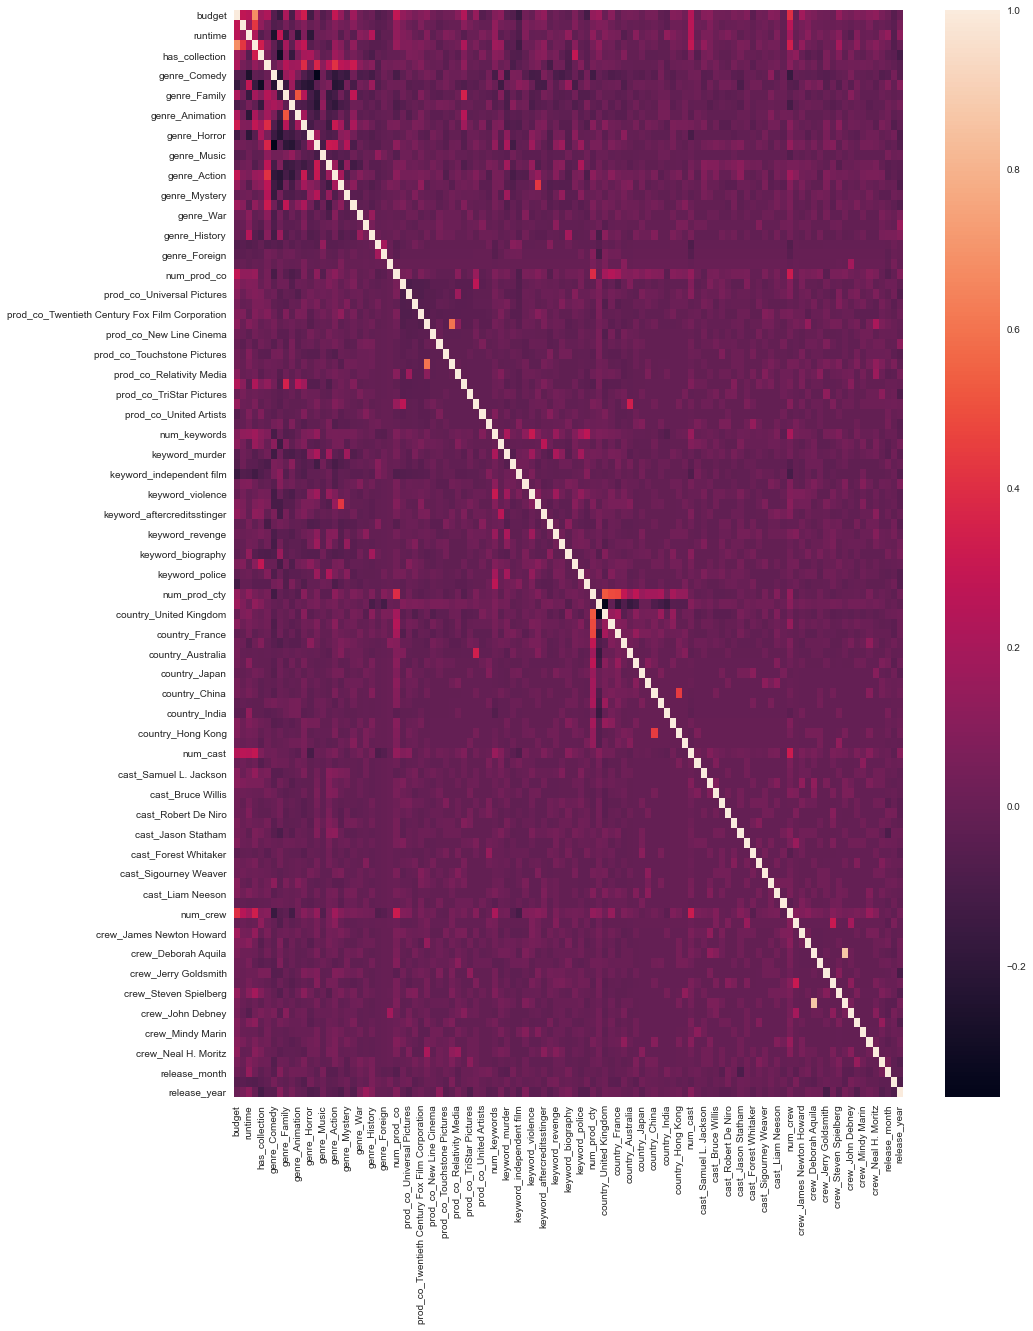

In [74]:
fig = plt.figure(figsize=(15, 20))
train_data4_corr = train_data4.corr()
ax = sns.heatmap(train_data4_corr)

In [75]:
train_data4_corr[['revenue']].sort_values(by=['revenue'],ascending = False)

,revenue
revenue,1.000000
budget,0.675196
popularity,0.429156
num_crew,0.338478
has_collection,0.329484
...,...
keyword_murder,-0.061316
genre_Crime,-0.061651
release_DOW,-0.066066
keyword_independent film,-0.126867


In [76]:
test_data4.shape

(2746, 108)

## One Hot Encoding

In [77]:
train_data5 = train_data4.copy()
test_data5 = test_data4.copy()

In [78]:
# One Hot Encoding on the dataset

train_data5 = pd.get_dummies(train_data4, drop_first=True )
test_data5 = pd.get_dummies(test_data4, drop_first=True )

In [79]:
train_data5.head()

,budget,popularity,runtime,revenue,has_collection,num_genres,genre_Comedy,genre_Drama,genre_Family,genre_Romance,genre_Animation,genre_Adventure,genre_Horror,genre_Thriller,genre_Music,genre_Crime,genre_Action,genre_Science Fiction,genre_Mystery,genre_Fantasy,genre_War,genre_Western,genre_History,genre_Documentary,genre_Foreign,genre_TV Movie,num_prod_co,prod_co_Warner Bros.,prod_co_Universal Pictures,prod_co_Paramount Pictures,prod_co_Twentieth Century Fox Film Corporation,prod_co_Columbia Pictures,prod_co_New Line Cinema,prod_co_Metro-Goldwyn-Mayer (MGM),prod_co_Touchstone Pictures,prod_co_Columbia Pictures Corporation,prod_co_Relativity Media,prod_co_Walt Disney Pictures,prod_co_TriStar Pictures,prod_co_Village Roadshow Pictures,prod_co_United Artists,prod_co_Miramax Films,num_keywords,keyword_duringcreditsstinger,keyword_murder,keyword_woman director,keyword_independent film,keyword_based on novel,keyword_violence,keyword_dystopia,keyword_aftercreditsstinger,keyword_sport,keyword_revenge,keyword_suspense,keyword_biography,keyword_sequel,keyword_police,keyword_sex,num_prod_cty,country_United States of America,country_United Kingdom,country_Germany,country_France,country_Canada,country_Australia,country_Italy,country_Japan,country_Spain,country_China,country_Ireland,country_India,country_Czech Republic,country_Hong Kong,country_New Zealand,num_cast,cast_J.K. Simmons,cast_Samuel L. Jackson,cast_Morgan Freeman,cast_Bruce Willis,cast_Bruce McGill,cast_Robert De Niro,cast_Nicolas Cage,cast_Jason Statham,cast_George Clooney,cast_Forest Whitaker,cast_Ed Harris,cast_Sigourney Weaver,cast_Owen Wilson,cast_Liam Neeson,cast_Keith David,num_crew,crew_Robert Rodriguez,crew_James Newton Howard,crew_Francine Maisler,crew_Deborah Aquila,crew_Avy Kaufman,crew_Jerry Goldsmith,crew_Mary Vernieu,crew_Steven Spielberg,crew_Tricia Wood,crew_John Debney,crew_Janet Hirshenson,crew_Mindy Marin,crew_John Papsidera,crew_Neal H. Moritz,crew_James Horner,release_month,release_DOW,release_year
0,14000000,6.575393,93.0,12314651,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,2015
1,40000000,8.248895,113.0,95149435,1,4,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,1,2004
2,3300000,64.299990,105.0,13092000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,4,2014
5,8000000,0.743274,83.0,3261638,0,3,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,1987
6,14000000,7.286477,92.0,85446075,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,2012


In [80]:
test_data5.head()

,budget,popularity,runtime,has_collection,num_genres,genre_Comedy,genre_Drama,genre_Family,genre_Romance,genre_Animation,genre_Adventure,genre_Horror,genre_Thriller,genre_Music,genre_Crime,genre_Action,genre_Science Fiction,genre_Mystery,genre_Fantasy,genre_War,genre_Western,genre_History,genre_Documentary,genre_Foreign,genre_TV Movie,num_prod_co,prod_co_Warner Bros.,prod_co_Universal Pictures,prod_co_Paramount Pictures,prod_co_Twentieth Century Fox Film Corporation,prod_co_Columbia Pictures,prod_co_New Line Cinema,prod_co_Metro-Goldwyn-Mayer (MGM),prod_co_Touchstone Pictures,prod_co_Columbia Pictures Corporation,prod_co_Relativity Media,prod_co_Walt Disney Pictures,prod_co_TriStar Pictures,prod_co_Village Roadshow Pictures,prod_co_United Artists,prod_co_Miramax Films,num_keywords,keyword_duringcreditsstinger,keyword_murder,keyword_woman director,keyword_independent film,keyword_based on novel,keyword_violence,keyword_dystopia,keyword_aftercreditsstinger,keyword_sport,keyword_revenge,keyword_suspense,keyword_biography,keyword_sequel,keyword_police,keyword_sex,num_prod_cty,country_United States of America,country_United Kingdom,country_Germany,country_France,country_Canada,country_Australia,country_Italy,country_Japan,country_Spain,country_China,country_Ireland,country_India,country_Czech Republic,country_Hong Kong,country_New Zealand,num_cast,cast_J.K. Simmons,cast_Samuel L. Jackson,cast_Morgan Freeman,cast_Bruce Willis,cast_Bruce McGill,cast_Robert De Niro,cast_Nicolas Cage,cast_Jason Statham,cast_George Clooney,cast_Forest Whitaker,cast_Ed Harris,cast_Sigourney Weaver,cast_Owen Wilson,cast_Liam Neeson,cast_Keith David,num_crew,crew_Robert Rodriguez,crew_James Newton Howard,crew_Francine Maisler,crew_Deborah Aquila,crew_Avy Kaufman,crew_Jerry Goldsmith,crew_Mary Vernieu,crew_Steven Spielberg,crew_Tricia Wood,crew_John Debney,crew_Janet Hirshenson,crew_Mindy Marin,crew_John Papsidera,crew_Neal H. Moritz,crew_James Horner,release_month,release_DOW,release_year
4,2000000,3.217680,92.0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,2,2005
7,30000000,7.023414,77.0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,3,2000
8,16500000,7.829737,120.0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,5,2007
9,90000000,17.547693,92.0,1,3,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,5,1999
10,2000000,0.262437,88.0,0,3,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,2005


## Defining X and Y Variables

In [82]:
# Defining X and Y variables for prediction

X_train = train_data5.drop('revenue', axis = 'columns')
Y_train = train_data5[['revenue']]

## Feature Selection using Extra Trees Regressor

In [83]:
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X_train, Y_train)

<ipython-input-83-d69bc0f6820c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  selection.fit(X_train, Y_train)


ExtraTreesRegressor()

In [84]:
print(selection.feature_importances_)

[4.19930371e-01 7.04446679e-02 2.75760536e-02 7.78686813e-02
 9.30302312e-03 7.73630529e-03 8.90594095e-03 2.94888414e-03
 9.50627654e-03 1.54479257e-02 2.04767382e-02 3.66745767e-03
 7.13581584e-03 3.26943427e-03 3.90093133e-03 6.13486102e-03
 4.45572704e-03 2.63842247e-03 5.06711350e-03 1.52510627e-03
 2.66355233e-04 7.63576146e-04 2.04798949e-05 1.69923178e-07
 1.33456845e-05 6.83637472e-03 5.75206477e-03 3.87054096e-03
 6.50657386e-03 6.08379158e-03 2.91157301e-03 5.21421235e-03
 7.06307245e-04 2.15695295e-03 6.60046381e-04 1.33569208e-03
 3.76012076e-03 2.65054607e-03 1.07093976e-03 1.89446783e-03
 5.39815603e-04 1.28463400e-02 5.68912243e-03 1.11125254e-03
 2.73836321e-03 1.36936100e-04 3.76010880e-03 1.56962469e-03
 1.46506274e-03 4.63174681e-03 7.01592398e-04 3.86873005e-03
 1.12650168e-02 5.08531462e-04 2.23227081e-03 9.52047276e-04
 2.40387927e-03 4.83946185e-03 6.64787876e-04 3.80937625e-03
 3.66234099e-03 1.27729446e-03 2.13956414e-03 1.27025875e-03
 3.12226335e-04 7.945881

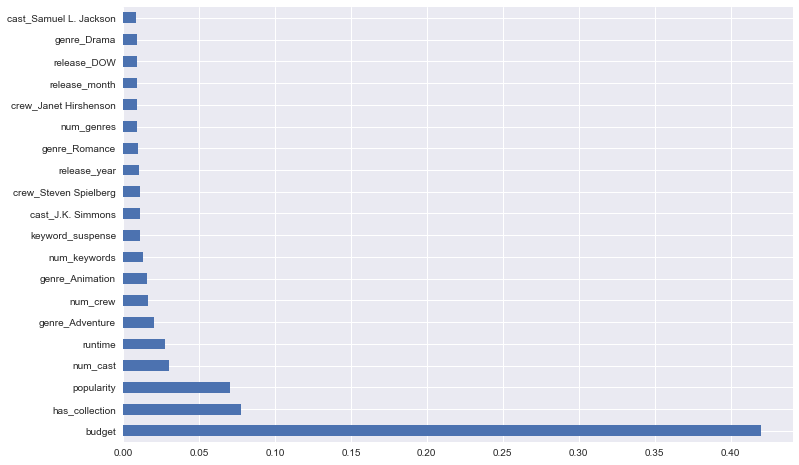

In [85]:
# Mapping the values of feature_importance to represent in bar graph. 

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X_train.columns)
imp_features = feat_importances.nlargest(20).plot(kind='barh')
plt.show()

We can cleary see how the features are impacting the revenue. We will select the top 20 features to train our model and check the accuracy. 

In [86]:
feat_importances.nlargest(20).keys()

Index(['budget', 'has_collection', 'popularity', 'num_cast', 'runtime',
       'genre_Adventure', 'num_crew', 'genre_Animation', 'num_keywords',
       'keyword_suspense', 'cast_J.K. Simmons', 'crew_Steven Spielberg',
       'release_year', 'genre_Romance', 'num_genres', 'crew_Janet Hirshenson',
       'release_month', 'release_DOW', 'genre_Drama',
       'cast_Samuel L. Jackson'],
      dtype='object')

In [87]:
X_train1 = train_data5[['budget', 'popularity', 'has_collection', 'genre_Adventure', 'runtime',
       'num_cast', 'num_crew', 'num_keywords', 'genre_Animation',
       'genre_Romance', 'release_month', 'keyword_duringcreditsstinger',
       'release_year', 'num_genres', 'crew_Janet Hirshenson',
       'cast_Samuel L. Jackson', 'cast_J.K. Simmons',
       'prod_co_Walt Disney Pictures', 'crew_Steven Spielberg', 'release_DOW']]

Y_train1 = Y_train = train_data5[['revenue']]

train_data6 = train_data5[['budget', 'popularity', 'has_collection', 'genre_Adventure', 'runtime',
       'num_cast', 'num_crew', 'num_keywords', 'genre_Animation',
       'genre_Romance', 'release_month', 'keyword_duringcreditsstinger',
       'release_year', 'num_genres', 'crew_Janet Hirshenson',
       'cast_Samuel L. Jackson', 'cast_J.K. Simmons',
       'prod_co_Walt Disney Pictures', 'crew_Steven Spielberg', 'release_DOW','revenue']]

### Feature Selection for Developing GUI

In [88]:
X_train.head()

,budget,popularity,runtime,has_collection,num_genres,genre_Comedy,genre_Drama,genre_Family,genre_Romance,genre_Animation,genre_Adventure,genre_Horror,genre_Thriller,genre_Music,genre_Crime,genre_Action,genre_Science Fiction,genre_Mystery,genre_Fantasy,genre_War,genre_Western,genre_History,genre_Documentary,genre_Foreign,genre_TV Movie,num_prod_co,prod_co_Warner Bros.,prod_co_Universal Pictures,prod_co_Paramount Pictures,prod_co_Twentieth Century Fox Film Corporation,prod_co_Columbia Pictures,prod_co_New Line Cinema,prod_co_Metro-Goldwyn-Mayer (MGM),prod_co_Touchstone Pictures,prod_co_Columbia Pictures Corporation,prod_co_Relativity Media,prod_co_Walt Disney Pictures,prod_co_TriStar Pictures,prod_co_Village Roadshow Pictures,prod_co_United Artists,prod_co_Miramax Films,num_keywords,keyword_duringcreditsstinger,keyword_murder,keyword_woman director,keyword_independent film,keyword_based on novel,keyword_violence,keyword_dystopia,keyword_aftercreditsstinger,keyword_sport,keyword_revenge,keyword_suspense,keyword_biography,keyword_sequel,keyword_police,keyword_sex,num_prod_cty,country_United States of America,country_United Kingdom,country_Germany,country_France,country_Canada,country_Australia,country_Italy,country_Japan,country_Spain,country_China,country_Ireland,country_India,country_Czech Republic,country_Hong Kong,country_New Zealand,num_cast,cast_J.K. Simmons,cast_Samuel L. Jackson,cast_Morgan Freeman,cast_Bruce Willis,cast_Bruce McGill,cast_Robert De Niro,cast_Nicolas Cage,cast_Jason Statham,cast_George Clooney,cast_Forest Whitaker,cast_Ed Harris,cast_Sigourney Weaver,cast_Owen Wilson,cast_Liam Neeson,cast_Keith David,num_crew,crew_Robert Rodriguez,crew_James Newton Howard,crew_Francine Maisler,crew_Deborah Aquila,crew_Avy Kaufman,crew_Jerry Goldsmith,crew_Mary Vernieu,crew_Steven Spielberg,crew_Tricia Wood,crew_John Debney,crew_Janet Hirshenson,crew_Mindy Marin,crew_John Papsidera,crew_Neal H. Moritz,crew_James Horner,release_month,release_DOW,release_year
0,14000000,6.575393,93.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,2015
1,40000000,8.248895,113.0,1,4,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,1,2004
2,3300000,64.299990,105.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,4,2014
5,8000000,0.743274,83.0,0,3,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,1987
6,14000000,7.286477,92.0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,2012


In [89]:
#X_train.keys()
X_train.groupby('release_year')['release_year'].agg('count')

release_year
1971    7
1972    4
1973    6
1974    3
1975    4
       ..
2066    3
2067    6
2068    3
2069    5
2070    7
Name: release_year, Length: 86, dtype: int64

Budget, Popularity, Runtime
Genre Checkbox: Comedy, Drama, Family, Romance, Animation, Adventure, Horror, Thriller, Crime, Action, Science Fiction, Mystery, War, History, Documentay
Production Company: Warner Bros., Universal Pictures, Paramount Pictures, Twentieth Century Fox Film Corporation, Columbia Pictures, New Line Cinema, Metro-Goldwyn-Mayer (MGM), Touchstone Pictures, Columbia Pictures Corporation, Relativity Media, Walt Disney Pictures, TriStar Pictures, Village Roadshow Pictures, United Artists, Miramax Films
    Keywords: Murder, Women Director, Independent Film, Based on novel, violence, dystopia, sport, revenge, suspense, biography, sequel, police, sex, duringcreditsstinger, aftercreditsstinger
Production Country: United States of America, United Kingdom, Germany, France, Canada, Australia, Italy, Japan, Spain, China, Ireland, India, Czech Repkublic, Hong Kong, New Zealand
Cast: J.K.Simmons, Samuel L.Jackson, Morgan Freeman, Bruce Willis, Bruce McGill, Robert De Niro, Nicolas Cage, Jason Statham, George Clooney, Forest Whitaker, Ed Harris, Sigourney Weaver, Owen Neeson, Liam Neeson, Keith David
Crew: Robert Rodriguez, James Newton Howard, Francine Maisler, Deborah Aquila, Avy Kaufman, Jerry Goldsmith, Mary Vernieu, Steven Spielberg, Tricia Wood, John Debney, Janet Hirshenson, Mindy Marin, John Papsidera, Neal H. Moritz, Neal H. Moritz, James Horner
Release Month
Release Date of Week
Release Year


In [90]:
# Removing the columns which are not needed

X_train2 = X_train.copy()

X_train2.drop(["num_genres"], axis = 1, inplace = True)
X_train2.drop(["genre_Music"], axis = 1, inplace = True)
X_train2.drop(["genre_Fantasy"], axis = 1, inplace = True)
X_train2.drop(["genre_Western"], axis = 1, inplace = True)
X_train2.drop(["genre_Foreign"], axis = 1, inplace = True)
X_train2.drop(["genre_TV Movie"], axis = 1, inplace = True)
X_train2.drop(["num_prod_co"], axis = 1, inplace = True)
X_train2.drop(["num_keywords"], axis = 1, inplace = True)
X_train2.drop(["num_prod_cty"], axis = 1, inplace = True)
X_train2.drop(["num_cast"], axis = 1, inplace = True)
X_train2.drop(["num_crew"], axis = 1, inplace = True)

In [91]:
X_train2.head()

,budget,popularity,runtime,has_collection,genre_Comedy,genre_Drama,genre_Family,genre_Romance,genre_Animation,genre_Adventure,genre_Horror,genre_Thriller,genre_Crime,genre_Action,genre_Science Fiction,genre_Mystery,genre_War,genre_History,genre_Documentary,prod_co_Warner Bros.,prod_co_Universal Pictures,prod_co_Paramount Pictures,prod_co_Twentieth Century Fox Film Corporation,prod_co_Columbia Pictures,prod_co_New Line Cinema,prod_co_Metro-Goldwyn-Mayer (MGM),prod_co_Touchstone Pictures,prod_co_Columbia Pictures Corporation,prod_co_Relativity Media,prod_co_Walt Disney Pictures,prod_co_TriStar Pictures,prod_co_Village Roadshow Pictures,prod_co_United Artists,prod_co_Miramax Films,keyword_duringcreditsstinger,keyword_murder,keyword_woman director,keyword_independent film,keyword_based on novel,keyword_violence,keyword_dystopia,keyword_aftercreditsstinger,keyword_sport,keyword_revenge,keyword_suspense,keyword_biography,keyword_sequel,keyword_police,keyword_sex,country_United States of America,country_United Kingdom,country_Germany,country_France,country_Canada,country_Australia,country_Italy,country_Japan,country_Spain,country_China,country_Ireland,country_India,country_Czech Republic,country_Hong Kong,country_New Zealand,cast_J.K. Simmons,cast_Samuel L. Jackson,cast_Morgan Freeman,cast_Bruce Willis,cast_Bruce McGill,cast_Robert De Niro,cast_Nicolas Cage,cast_Jason Statham,cast_George Clooney,cast_Forest Whitaker,cast_Ed Harris,cast_Sigourney Weaver,cast_Owen Wilson,cast_Liam Neeson,cast_Keith David,crew_Robert Rodriguez,crew_James Newton Howard,crew_Francine Maisler,crew_Deborah Aquila,crew_Avy Kaufman,crew_Jerry Goldsmith,crew_Mary Vernieu,crew_Steven Spielberg,crew_Tricia Wood,crew_John Debney,crew_Janet Hirshenson,crew_Mindy Marin,crew_John Papsidera,crew_Neal H. Moritz,crew_James Horner,release_month,release_DOW,release_year
0,14000000,6.575393,93.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,2015
1,40000000,8.248895,113.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,1,2004
2,3300000,64.299990,105.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,4,2014
5,8000000,0.743274,83.0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,1987
6,14000000,7.286477,92.0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,2012


In [92]:
# Rearranging columns

X_train3 = X_train2[['budget','popularity','runtime','release_year','release_month','release_DOW','genre_Comedy','genre_Drama',
'genre_Family', 'genre_Romance', 'genre_Animation','genre_Adventure', 'genre_Horror', 'genre_Thriller','genre_Crime',
'genre_Action','genre_Science Fiction','genre_Mystery','genre_War','genre_History','genre_Documentary','prod_co_Warner Bros.',
'prod_co_Universal Pictures','prod_co_Paramount Pictures','prod_co_Twentieth Century Fox Film Corporation','prod_co_Columbia Pictures',
'prod_co_New Line Cinema','prod_co_Metro-Goldwyn-Mayer (MGM)','prod_co_Touchstone Pictures','prod_co_Columbia Pictures Corporation',
'prod_co_Relativity Media','prod_co_Walt Disney Pictures','prod_co_TriStar Pictures','prod_co_Village Roadshow Pictures',
'prod_co_United Artists','prod_co_Miramax Films','country_United States of America','country_United Kingdom','country_Germany',
'country_France','country_Canada','country_Australia','country_Italy','country_Japan','country_Spain','country_China',
'country_Ireland','country_India','country_Czech Republic','country_Hong Kong','country_New Zealand','keyword_murder',
'keyword_woman director','keyword_independent film','keyword_based on novel','keyword_violence','keyword_dystopia','keyword_sport',
'keyword_revenge','keyword_suspense','keyword_biography','keyword_sequel','keyword_police','keyword_sex','keyword_duringcreditsstinger',
'keyword_aftercreditsstinger','cast_J.K. Simmons','cast_Samuel L. Jackson','cast_Morgan Freeman','cast_Bruce Willis','cast_Bruce McGill',
'cast_Robert De Niro','cast_Nicolas Cage','cast_Jason Statham','cast_George Clooney','cast_Forest Whitaker','cast_Ed Harris',
'cast_Sigourney Weaver','cast_Owen Wilson','cast_Liam Neeson','cast_Keith David','crew_Robert Rodriguez','crew_James Newton Howard',
'crew_Francine Maisler','crew_Deborah Aquila','crew_Avy Kaufman','crew_Jerry Goldsmith','crew_Mary Vernieu','crew_Steven Spielberg',
'crew_Tricia Wood','crew_John Debney','crew_Janet Hirshenson','crew_Mindy Marin','crew_John Papsidera','crew_Neal H. Moritz',
'crew_James Horner']]

In [93]:
X_train3.shape

(1881, 96)

## Model Building

### 1. Model Build on all attributes

In [94]:
lr_model = LinearRegression()
result = lr_model.fit(X_train, Y_train)

In [95]:
# Evalation on training set

Y_train_predict = lr_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_predict)))
r2 = r2_score(Y_train, Y_train_predict)

print("The model performance for training set:")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
accuracy = r2*100
print("\nThe Accuracy of the model is: {}% ".format(accuracy))

The model performance for training set:
RMSE is 81644892.96851757
R2 score is 0.6382280268771761

The Accuracy of the model is: 63.822802687717605% 


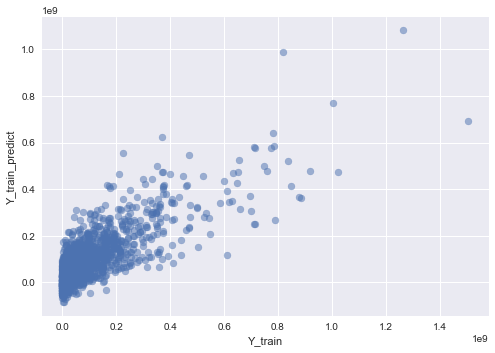

In [96]:
# Scatter Plot of Y_train Vs Y_train_predict

plt.scatter(Y_train, Y_train_predict, alpha = 0.5)
plt.xlabel("Y_train")
plt.ylabel("Y_train_predict")
plt.show()

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


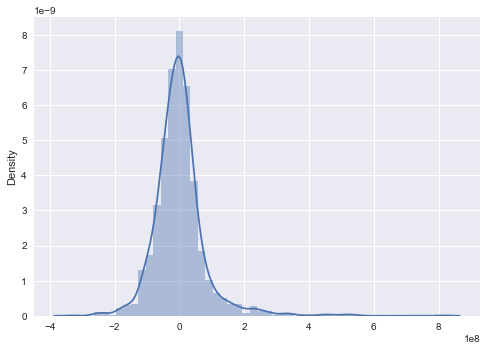

In [97]:
# Residual Plot

sns.distplot(Y_train - Y_train_predict)
plt.show()

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


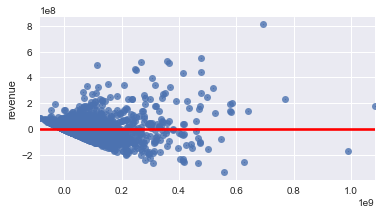

In [98]:
#Diagnosis of Model
#Checking Linearity Assusmption and Constant Variance of Residual Terms

residual = Y_train - Y_train_predict
fig, ax = plt.subplots(figsize=(6,3))
_ = ax.scatter(Y_train_predict , residual, s = 1)
sns.regplot(Y_train_predict, residual, order = 1, ci=None, line_kws={'color':'r'})
plt.show()

### Cross Validation

In [99]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [100]:
folds = StratifiedKFold(n_splits=20)

In [101]:
accuracy_cv = cross_val_score(LinearRegression(),X_train,Y_train,cv=10)
print(accuracy_cv)

[0.58742397 0.49416149 0.61590796 0.6957849  0.41241939 0.58089259
 0.70305749 0.53440852 0.4699036  0.47251906]


In [102]:
accuracy, count = 0,0
for i in accuracy_cv:
    count = count + 1
    accuracy = accuracy + i
print("Accuracy: ",accuracy/count)

Accuracy:  0.5566478972912209


### 2. Model Training on 20 attributes which impact most to Revenue

In [103]:
# Model training

lr_model1 = LinearRegression()
result = lr_model1.fit(X_train1, Y_train1)

In [106]:
train_MSE = np.mean((Y_train1 - result.predict(X_train1))**2)
print("RMSE =",np.sqrt(train_MSE))
r2 = result.score(X_train1, Y_train1)
print(r2)

RMSE = revenue    8.472495e+07
dtype: float64
0.6104174123910499


In [108]:
r2 = r2_score(Y_train, Y_train_predict)
print(r2*100)

63.822802687717605


In [109]:
print("The Accuracy of Random Forest model build by choosing top 20 attributes that impact Revenue most is: ",r2*100)

The Accuracy of Random Forest model build by choosing top 20 attributes that impact Revenue most is:  63.822802687717605


### Cross Validation

In [110]:
folds = StratifiedKFold(n_splits=20)

In [111]:
accuracy_cv = cross_val_score(LinearRegression(),X_train1,Y_train1,cv=10)
print(accuracy_cv)

[0.59679464 0.55911231 0.61654328 0.71941103 0.45406585 0.5768729
 0.71395118 0.56265641 0.47761362 0.53894803]


In [112]:
accuracy, count = 0,0
for i in accuracy_cv:
    count = count + 1
    accuracy = accuracy + i
accuracy = (accuracy/count)*100
print("Accuracy: {}%".format(accuracy))

Accuracy: 58.15969239734701%


### 3. Model training using Regularization Techniques

L1 Regularization : Lasso

1. L1 Regularization on data with all attributes

In [117]:
from sklearn import linear_model 

lasso_reg = linear_model.Lasso(alpha=50, max_iter=150, tol=0.1)
lasso_reg.fit(X_train,Y_train)

r2 = lasso_reg.score(X_train,Y_train)
print(r2)

0.6382280256060541


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.884027122938959e+18, tolerance: 3.4658672561767035e+18
  model = cd_fast.enet_coordinate_descent(


2. L1 Regularization on data with 20 attributes that impact the Revenue the most

In [114]:
from sklearn import linear_model 

lasso_reg = linear_model.Lasso(alpha=50, max_iter=150, tol=0.1)
lasso_reg.fit(X_train1,Y_train1)

lasso_reg.score(X_train1,Y_train1)

0.6104174123336579

We can see that after regularization the prediction score has been improved and we got an accuracy of 60%. 

L2 Regularization : Ridge

In [115]:
from sklearn.linear_model import Ridge 

ridge_reg = Ridge(alpha=50, max_iter=100, tol=0.1)
ridge_reg.fit(X_train1,Y_train1)

ridge_reg.score(X_train1,Y_train1)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.00087e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


0.6002683063854722

Ridge Regularization did give us a score less than L1 Regularization. So we will consider Lasso Regularization method. 

In [116]:
print("The Accuracy of Regression model using Lasso Regularization on all attributes is: ",r2*100)

The Accuracy of Regression model using Lasso Regularization on all attributes is:  63.82280256060541


### 4. Random Forest Model on all attributes

In [118]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, Y_train)

<ipython-input-118-c332f1a5ad6e>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_rf.fit(X_train, Y_train)


RandomForestRegressor()

In [119]:
r2 = reg_rf.score(X_train, Y_train)

In [120]:
Y_train_pred = reg_rf.predict(X_train)

In [121]:
r2 = r2_score(Y_train, Y_train_pred)
print(r2*100)

94.18855729878057


In [122]:
Y_train.shape

(1881, 1)

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


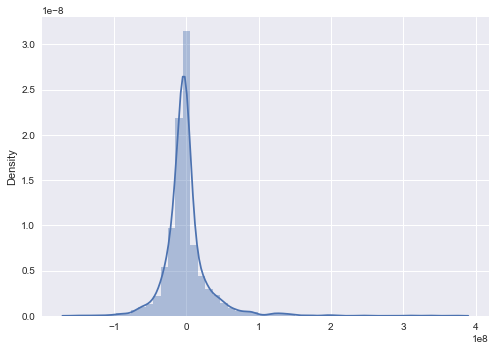

In [123]:
# Residual Plot

Y_train_pred = Y_train_pred.reshape(1881,1)
sns.distplot(Y_train - Y_train_pred)
plt.show()

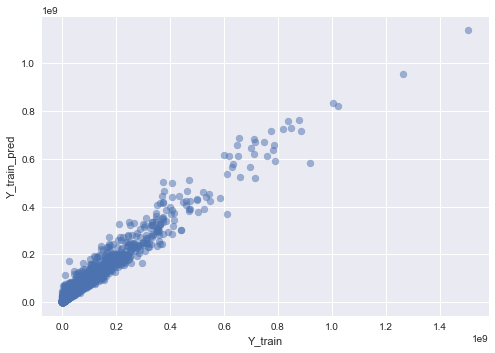

In [124]:
plt.scatter(Y_train, Y_train_pred, alpha = 0.5)
plt.xlabel("Y_train")
plt.ylabel("Y_train_pred")
plt.show()

In [125]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(Y_train, Y_train_pred))
print('MSE:', metrics.mean_squared_error(Y_train, Y_train_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_train, Y_train_pred)))

MAE: 18249036.309962787
MSE: 1070796861738625.9
RMSE: 32723032.58774507


In [126]:
print("The Accuracy of Random Forest model build by choosing top 20 attributes that impact Revenue most is: ",r2*100)

The Accuracy of Random Forest model build by choosing top 20 attributes that impact Revenue most is:  94.18855729878057


### 5. Random Forest Model on 20 attributes that impact most Revenue

In [127]:
from sklearn.ensemble import RandomForestRegressor
reg_rf1 = RandomForestRegressor()
reg_rf1.fit(X_train1, Y_train1)

<ipython-input-127-62fff8ccb59c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_rf1.fit(X_train1, Y_train1)


RandomForestRegressor()

In [130]:
r2 = reg_rf1.score(X_train1, Y_train1)
print(r2*100)

94.19599821108751


In [129]:
r2 = r2_score(Y_train, Y_train_predict)
print(r2*100)

63.822802687717605


In [131]:
print("The Accuracy of Random Forest model build by choosing top 20 attributes that impact Revenue most is: ",r2*100)

The Accuracy of Random Forest model build by choosing top 20 attributes that impact Revenue most is:  94.19599821108751


### 6. Random Forest Model on GUI attributes

In [132]:
# Original Dataset

X_train3.head()

,budget,popularity,runtime,release_year,release_month,release_DOW,genre_Comedy,genre_Drama,genre_Family,genre_Romance,genre_Animation,genre_Adventure,genre_Horror,genre_Thriller,genre_Crime,genre_Action,genre_Science Fiction,genre_Mystery,genre_War,genre_History,genre_Documentary,prod_co_Warner Bros.,prod_co_Universal Pictures,prod_co_Paramount Pictures,prod_co_Twentieth Century Fox Film Corporation,prod_co_Columbia Pictures,prod_co_New Line Cinema,prod_co_Metro-Goldwyn-Mayer (MGM),prod_co_Touchstone Pictures,prod_co_Columbia Pictures Corporation,prod_co_Relativity Media,prod_co_Walt Disney Pictures,prod_co_TriStar Pictures,prod_co_Village Roadshow Pictures,prod_co_United Artists,prod_co_Miramax Films,country_United States of America,country_United Kingdom,country_Germany,country_France,country_Canada,country_Australia,country_Italy,country_Japan,country_Spain,country_China,country_Ireland,country_India,country_Czech Republic,country_Hong Kong,country_New Zealand,keyword_murder,keyword_woman director,keyword_independent film,keyword_based on novel,keyword_violence,keyword_dystopia,keyword_sport,keyword_revenge,keyword_suspense,keyword_biography,keyword_sequel,keyword_police,keyword_sex,keyword_duringcreditsstinger,keyword_aftercreditsstinger,cast_J.K. Simmons,cast_Samuel L. Jackson,cast_Morgan Freeman,cast_Bruce Willis,cast_Bruce McGill,cast_Robert De Niro,cast_Nicolas Cage,cast_Jason Statham,cast_George Clooney,cast_Forest Whitaker,cast_Ed Harris,cast_Sigourney Weaver,cast_Owen Wilson,cast_Liam Neeson,cast_Keith David,crew_Robert Rodriguez,crew_James Newton Howard,crew_Francine Maisler,crew_Deborah Aquila,crew_Avy Kaufman,crew_Jerry Goldsmith,crew_Mary Vernieu,crew_Steven Spielberg,crew_Tricia Wood,crew_John Debney,crew_Janet Hirshenson,crew_Mindy Marin,crew_John Papsidera,crew_Neal H. Moritz,crew_James Horner
0,14000000,6.575393,93.0,2015,2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40000000,8.248895,113.0,2004,6,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3300000,64.299990,105.0,2014,10,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,8000000,0.743274,83.0,1987,6,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,14000000,7.286477,92.0,2012,8,3,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [133]:
from sklearn.ensemble import RandomForestRegressor
reg_rf2 = RandomForestRegressor()
reg_rf2.fit(X_train3, Y_train1)

<ipython-input-133-5faa0aec87dc>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg_rf2.fit(X_train3, Y_train1)


RandomForestRegressor()

In [134]:
Y_train_pred = reg_rf2.predict(X_train3)

In [135]:
r2 = reg_rf2.score(X_train3, Y_train1)
print(r2)

0.9392921849055506


In [136]:
metrics.r2_score(Y_train, Y_train_pred)

0.9392921849055506

In [137]:
print("The Accuracy of Random Forest model build on GUI attributes: ",r2*100)

The Accuracy of Random Forest model build on GUI attributes:  93.92921849055506


In [138]:
Y_train_pred.shape

(1881,)

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


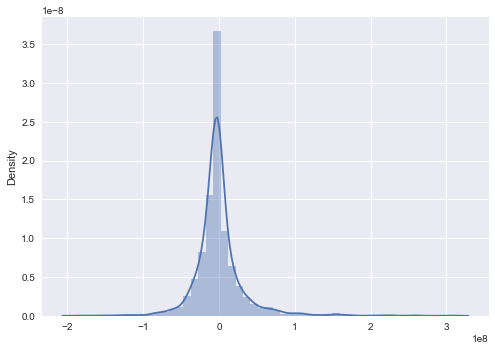

In [139]:
# Residual Plot

Y_train_pred = Y_train_pred.reshape(1881,1)
sns.distplot(Y_train - Y_train_pred)
plt.show()

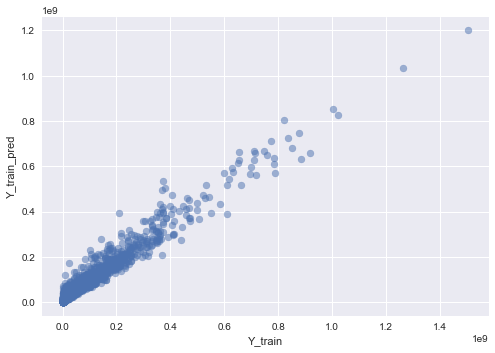

In [140]:
plt.scatter(Y_train, Y_train_pred, alpha = 0.5)
plt.xlabel("Y_train")
plt.ylabel("Y_train_pred")
plt.show()

## Save model in pickle file 

In [150]:
import pickle
# open a file, where you ant to store the data
file = open('revenue_rf2.pkl', 'wb')

# dump information to that file
pickle.dump(reg_rf2, file)

In [151]:
model = open('revenue_rf2.pkl','rb')
forest = pickle.load(model)

In [152]:
file.close()